<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/autocorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autocorrelation

*Author: Alexander Del Toro Barba*

**Import Libraries**

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from scipy import stats

# Create Data

**Random Walk Process**

In [0]:
import numpy as np
def geometric_brownian_motion(T = 1, N = 100, mu = 0.1, sigma = 0.01, S0 = 20):        
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt) ### standard brownian motion ###
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion ###
    return S

dates = pd.date_range('2012-01-01', '2019-02-22')
T = (dates.max()-dates.min()).days / 365
N = dates.size
start_price = 100
randomwalk = pd.Series(
    geometric_brownian_motion(T, N, sigma=0.1, S0=start_price), index=dates)

**White Noise Process**

In [0]:
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot

# seed random number generator
seed(1)

# create white noise series
whitenoise = [gauss(0.0, 1.0) for i in range(3000)]
whitenoise = Series(whitenoise)

# Random Walk Process

## Summary

In [0]:
randomwalk.describe()

count    2610.000000
mean      170.566344
std        45.394024
min        95.614432
25%       131.757861
50%       173.825076
75%       203.643394
max       278.546946
dtype: float64

Text(0, 0.5, 'Value')

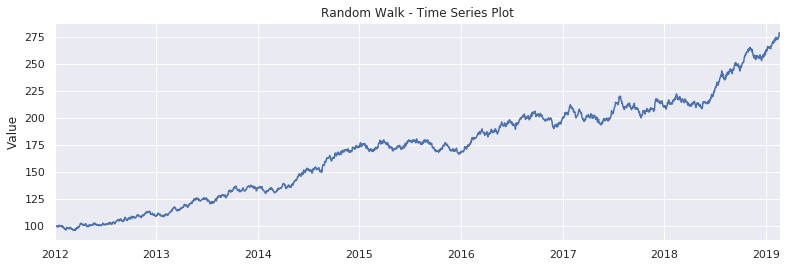

In [0]:
df = randomwalk
sns.set(rc={'figure.figsize':(13, 4)})
df.plot(linewidth=1.5,title='Random Walk - Time Series Plot')
plt.ylabel('Value')

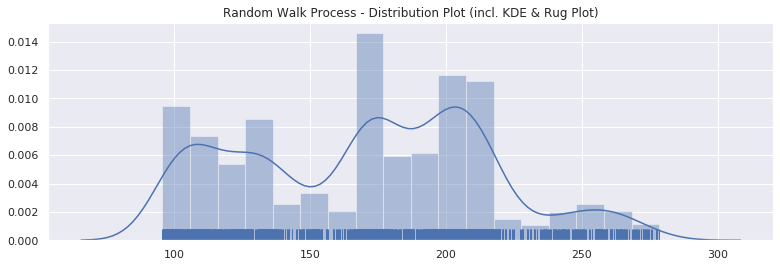

In [0]:
df = randomwalk
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((df), hist=True, rug=True).set_title('Random Walk Process - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

## Autocorrelation Plot

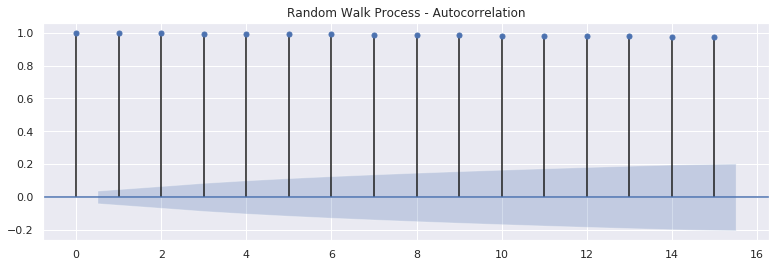

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sm.graphics.tsa.plot_acf(randomwalk.squeeze(), lags=15)
plt.title('Random Walk Process - Autocorrelation')
plt.show()

## Autocorrelation Lag Plot

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


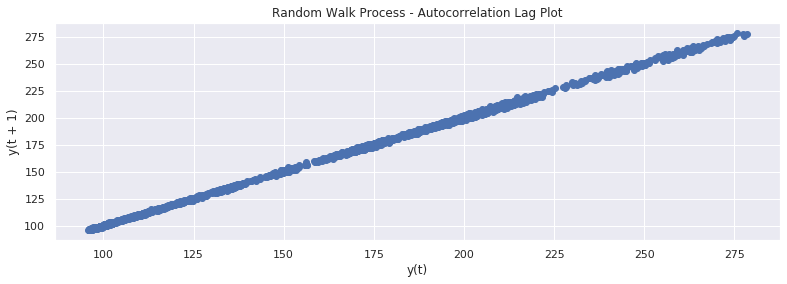

In [0]:
from pandas.plotting import lag_plot
lag_plot(randomwalk)
plt.title('Random Walk Process - Autocorrelation Lag Plot')
plt.show()

## Portmanteau & Autocorrelation Tests

Portmanteau-Tests sind statistische Tests, mit deren Hilfe für mehrere Autokorrelationskoeffizienten getestet werden kann, ob sie sich signifikant von null unterscheiden. Dies ist vor allem bei der Prüfung der Autokorrelationsfreiheit der Residuen im Rahmen der Diagnosephase einer Zeitreihenanalyse wichtig.
Portmanteau-Tests sind reine Signifikanztests. Sie testen nicht gegen eine klar formulierte Gegenhypothese.
Die Teststatistik wird Q-Statistik genannt.

**Durbin-Watson Test**

Used in autoregressive models
The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical regression analysis. The Durbin-Watson statistic will always have a value between 0 and 4. 
A value of 2.0 means that there is no autocorrelation detected in the sample. Values from 0 to less than 2 indicate positive autocorrelation and values from from 2 to 4 indicate negative autocorrelation. 
A stock price displaying positive autocorrelation would indicate that the price yesterday has a positive correlation on the price today—so if the stock fell yesterday, it is also likely that it falls today. A security that has a negative autocorrelation, on the other hand, has a negative influence on itself over time—so that if it fell yesterday, there is a greater likelihood it will rise today.

In [0]:
# Durbin-Watson test to assess autocorrelation
# The null hypothesis of the test is that there is no serial correlation
# This statistic will always be between 0 and 4. 
# The closer to 0 the statistic, the more evidence for positive serial correlation. 
# The closer to 4, the more evidence for negative serial correlation.
statsmodels.stats.stattools.durbin_watson(randomwalk, axis=0)

2.7780525590375084e-05

**Ljung-Box Q Statistic**

Ljung–Box test is an improved version of the Box–Pierce test

In [0]:
# Ljung-Box Q Statistic
# Returns Ljung-Box Q-statistic for autocorrelation parameters and p-value
# examining the null hypothesis of independence in a given time series. These are sometimes known as ‘portmanteau’ tests.
# statsmodels.tsa.stattools.q_stat(randomwalk, nobs=10, type='ljungbox')

**Breusch–Godfrey Test**

Tests for the presence of serial correlation that has not been included in a proposed model structure and which, if present, would mean that incorrect conclusions would be drawn from other tests, or that sub-optimal estimates of model parameters are obtained if it is not taken into account.

**Important:**

There are some strong voices in the Econometrics community against the validity of the Ljung-Box Q-statistic for testing for autocorrelation based on the residuals from an autoregressive model (i.e. with lagged dependent variables in the regressor matrix), see particularly Maddala (2001) "Introduction to Econometrics (3d edition), ch 6.7, and 13. 5 p 528. Maddala literally laments the widespread use of this test, and instead considers as appropriate the "Langrange Multiplier" test of Breusch and Godfrey.

Maddala's argument against the Ljung-Box test is the same as the one raised against another omnipresent autocorrelation test, the "Durbin-Watson" one: with lagged dependent variables in the regressor matrix, the test is biased in favor of maintaining the null hypothesis of "no-autocorrelation" (the Monte-Carlo results obtained in @javlacalle answer allude to this fact). Maddala also mentions the low power of the test, see for example Davies, N., & Newbold, P. (1979). Some power studies of a portmanteau test of time series model specification. Biometrika, 66(1), 153-155.

In [0]:
# Breusch–Godfrey Test

# White Noise Process

## Summary

In [0]:
whitenoise.describe()

count    3000.000000
mean        0.007780
std         0.995494
min        -3.149965
25%        -0.648906
50%         0.005181
75%         0.689631
max         3.284978
dtype: float64

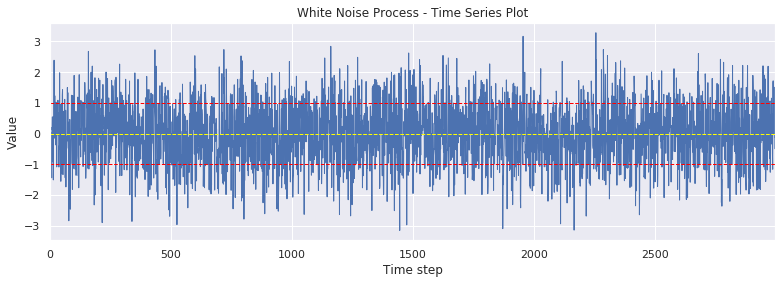

In [0]:
df = whitenoise
sns.set(rc={'figure.figsize':(13, 4)})
df.plot(linewidth=1.0,title='White Noise Process - Time Series Plot')
plt.ylabel('Value')
plt.xlabel('Time step')
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.0);
plt.axhline(y=-1, color='red', linestyle='--', linewidth=1.0);
plt.axhline(y=0, color='yellow', linestyle='--', linewidth=1.0);

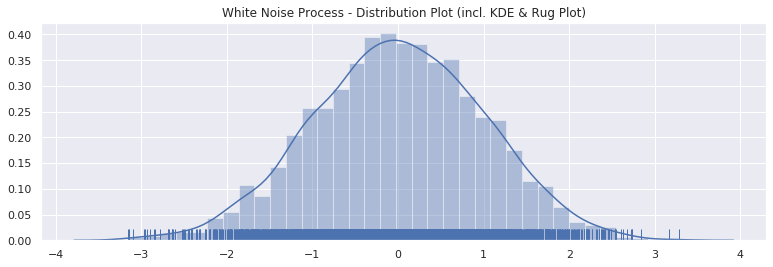

In [0]:
df = whitenoise
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((df), hist=True, rug=True).set_title('White Noise Process - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

## Autocorrelation Plot

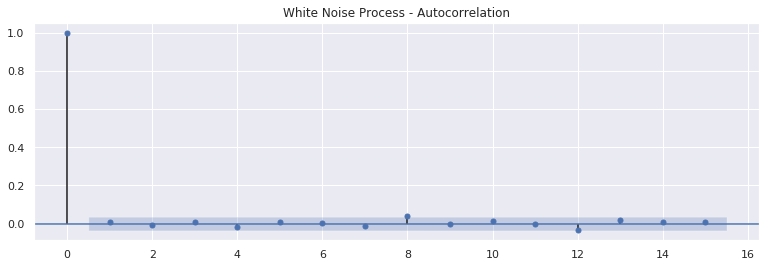

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sm.graphics.tsa.plot_acf(whitenoise.squeeze(), lags=15)
plt.title('White Noise Process - Autocorrelation')
plt.show()

## Autocorrelation Lag Plot

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


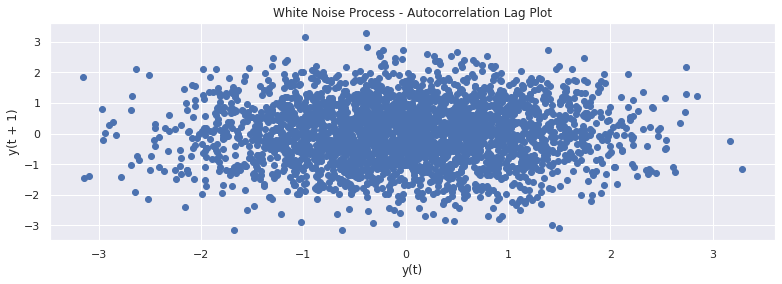

In [0]:
from pandas.plotting import lag_plot
lag_plot(whitenoise)
plt.title('White Noise Process - Autocorrelation Lag Plot')
plt.show()

## Portmanteau & Autocorrelation Tests

Portmanteau-Tests sind statistische Tests, mit deren Hilfe für mehrere Autokorrelationskoeffizienten getestet werden kann, ob sie sich signifikant von null unterscheiden. Dies ist vor allem bei der Prüfung der Autokorrelationsfreiheit der Residuen im Rahmen der Diagnosephase einer Zeitreihenanalyse wichtig.
Portmanteau-Tests sind reine Signifikanztests. Sie testen nicht gegen eine klar formulierte Gegenhypothese.
Die Teststatistik wird Q-Statistik genannt.

**Durbin-Watson Test**

Used in autoregressive models
The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical regression analysis. The Durbin-Watson statistic will always have a value between 0 and 4. 
A value of 2.0 means that there is no autocorrelation detected in the sample. Values from 0 to less than 2 indicate positive autocorrelation and values from from 2 to 4 indicate negative autocorrelation. 
A stock price displaying positive autocorrelation would indicate that the price yesterday has a positive correlation on the price today—so if the stock fell yesterday, it is also likely that it falls today. A security that has a negative autocorrelation, on the other hand, has a negative influence on itself over time—so that if it fell yesterday, there is a greater likelihood it will rise today.

In [0]:
# Durbin-Watson test to assess autocorrelation
# The null hypothesis of the test is that there is no serial correlation
# This statistic will always be between 0 and 4. 
# The closer to 0 the statistic, the more evidence for positive serial correlation. 
# The closer to 4, the more evidence for negative serial correlation.
statsmodels.stats.stattools.durbin_watson(whitenoise, axis=0)

1.9788141756267819

**Ljung-Box Q Statistic**

Ljung–Box test is an improved version of the Box–Pierce test

In [0]:
# Ljung-Box Q Statistic
# Returns Ljung-Box Q-statistic for autocorrelation parameters and p-value
# examining the null hypothesis of independence in a given time series. These are sometimes known as ‘portmanteau’ tests.
# statsmodels.tsa.stattools.q_stat(whitenoiseresiduals.value, nobs=10, type='ljungbox')

**Breusch–Godfrey Test**

Tests for the presence of serial correlation that has not been included in a proposed model structure and which, if present, would mean that incorrect conclusions would be drawn from other tests, or that sub-optimal estimates of model parameters are obtained if it is not taken into account.

**Important:**

There are some strong voices in the Econometrics community against the validity of the Ljung-Box Q-statistic for testing for autocorrelation based on the residuals from an autoregressive model (i.e. with lagged dependent variables in the regressor matrix), see particularly Maddala (2001) "Introduction to Econometrics (3d edition), ch 6.7, and 13. 5 p 528. Maddala literally laments the widespread use of this test, and instead considers as appropriate the "Langrange Multiplier" test of Breusch and Godfrey.

Maddala's argument against the Ljung-Box test is the same as the one raised against another omnipresent autocorrelation test, the "Durbin-Watson" one: with lagged dependent variables in the regressor matrix, the test is biased in favor of maintaining the null hypothesis of "no-autocorrelation" (the Monte-Carlo results obtained in @javlacalle answer allude to this fact). Maddala also mentions the low power of the test, see for example Davies, N., & Newbold, P. (1979). Some power studies of a portmanteau test of time series model specification. Biometrika, 66(1), 153-155.

In [0]:
# Breusch–Godfrey Test